<a href="https://colab.research.google.com/github/DsMikeMelo/Projects---Mike/blob/main/26_8_Sales_Prediction_Previs%C3%A3o_de_Vendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# 1 -  0.0 IMPORTS

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
import inflection
import datetime as datetime
import xgboost as xgb
import random
import warnings
import sklearn
import boruta

from scipy import stats as ss
from tabulate import tabulate
from sklearn.preprocessing import RobustScaler , MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

1.1  0.1. Helper Functions

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):

    
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range (1, kfold+1) ):
        if verbose:
            print('\nkfold number:{}'.format(k) )
            validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
            validation_end_date = x_training['date'].max() - datetime.timedelta(days =(k-1)*6*7)

            #filtering dataset

            training = x_training[x_training['date']< validation_start_date]

            validation = x_training[(x_training['date']>= validation_start_date) & (x_training['date']<= validation_end_date)]

            #training and validation dataset

            xtraining = training.drop(['date','sales'],axis = 1)
            ytraining = training['sales']


            xvalidation = validation.drop(['date','sales'],axis = 1)
            yvalidation = validation['sales']

            #model

            lr = LinearRegression().fit(xtraining,ytraining)

            #prediction

            yhat_lr = lr.predict(xvalidation)

            #performance
            lr_result = ml_error('Linear Regression',np.expm1(yvalidation),np.expm1(yhat_lr))

            #store performance

            mae_list.append( lr_result['MAE'])
            mape_list.append( lr_result['MAPE'])
            rmse_list.append( lr_result['RMSE'])

            return pd.DataFrame( {'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, index=[0] )


        

In [ ]:
def mean_absolute_percentage_error(y,yhat):
    
    return np.mean(np.abs( (y-yhat)/ y) )



In [ ]:
def ml_error(model_name, y ,yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape ,
                        'RMSE': rmse},index=[0])
  

In [ ]:
def cramer_v (x,y):
    cm = pd.crosstab (x , y).values
    n = cm.sum()
    r, k  = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max (0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)
    
    return np.sqrt ((chi2corr/n) / (min (kcorr-1,rcorr-1)))

1.2    0.2. Loading data

In [ ]:
#Importação dos dados
dataset_train = "/content/train.csv"
dataset_store = "/content/store.csv"


In [ ]:
df_sales_raw = pd.read_csv( dataset_train, low_memory=False )
df_store_raw = pd.read_csv( dataset_store, low_memory=False )
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 2         1.0. STEP 01 - DATA DESCRIPTION

In [ ]:
df1 = df_raw.copy()


2.1 1.1. Rename Columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
# rename
df1.columns = cols_new


2.2 1.2. Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


2.3 1.3. Data Types

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

2.4 1.4. Checking NA

In [ ]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [ ]:
df1['state_holiday'].astype(object)

0          0
1          0
2          0
3          0
4          0
          ..
1017204    a
1017205    a
1017206    a
1017207    a
1017208    a
Name: state_holiday, Length: 1017209, dtype: object

In [ ]:
#splitting two dataframes in numerical and nonnumerical6
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float4','datetime64[ns]'] )


In [ ]:
#competition_distance
df1['competition_distance']= df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else  x)

In [ ]:
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                
                                                math.isnan(x['competition_open_since_month'])
                                                                                
                                                 else x ['competition_open_since_month'] ,axis=1)

In [ ]:
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x:x['date'].year if 
                                               
                                          math.isnan(x['competition_open_since_year']) else
                                               
                                               x['competition_open_since_year'], axis=1)

In [ ]:
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) else
                                     x['promo2_since_week'], axis=1 )

In [ ]:
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [ ]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun'
,7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [ ]:
df1['promo_interval'].fillna(0,inplace = True)

In [ ]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [ ]:
df1.sample(5).T

,725679,501953,1016158,195571,151090
store,600,989,64,447,566
day_of_week,4,2,2,5,3
date,2013-09-19 00:00:00,2014-04-08 00:00:00,2013-01-01 00:00:00,2015-02-06 00:00:00,2015-03-18 00:00:00
sales,4789,4376,0,5890,6506
customers,503,509,0,645,605
open,1,1,0,1,1
promo,0,0,0,1,1
state_holiday,0,0,a,0,0
school_holiday,0,0,1,0,0
store_type,d,a,d,a,a


In [ ]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [ ]:
df1['month_map'] = df1['date'].dt.month.map( month_map )


In [ ]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].
split( ',' ) else 0, axis=1 )

2.5 1.5. Changing Data Types


In [ ]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int )
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

2.6 1.6. Descriptive Statistics

In [ ]:

num_attributtes = df1.select_dtypes( include =['int64','float64'])
cat_attributtes = df1.select_dtypes( exclude =['int64','float64','datetime64[ns]'])

In [ ]:
#cat_attributtes.sample(2)

2.7.1 1.7.1. Numerical Atributes


In [ ]:
#central tendency

ct1 = pd.DataFrame(num_attributtes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributtes.apply(np.median) ).T

# dispersion std, min

d1 = pd.DataFrame(num_attributtes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributtes.apply(min )).T
d3 = pd.DataFrame(num_attributtes.apply(max )).T
d4 = pd.DataFrame(num_attributtes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributtes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributtes.apply(lambda x: x.kurtosis() )).T

#concate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns =  ['attributes','min','max','range','mean','median','std','sknew','kurtosis']
m

,attributes,min,max,range,mean,median,std,sknew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


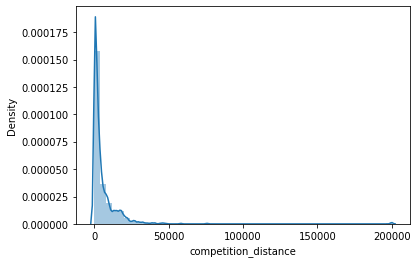

In [ ]:
sns.distplot(df1['competition_distance'])


2.7.2 1.7.2. Categorical Atributes

In [ ]:
cat_attributtes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

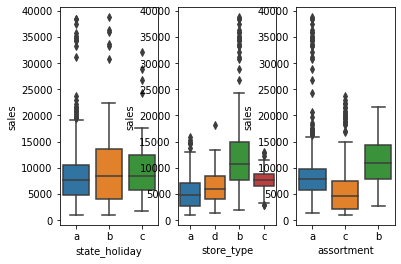

In [ ]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )

sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )

sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )

sns.boxplot( x='assortment', y='sales', data=aux )

plt.show()

#3  2.0. STEP 02- FEATURE ENGINEERING


In [ ]:
df2 = df1.copy()

In [ ]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


3.1 1.0 Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [ ]:
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(
year=x['competition_open_since_year'],
month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30
).apply( lambda x: x.days ).astype( int )

In [ ]:
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(
lambda x: x.days ).astype( int )


In [ ]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x =='a' else 'extra' if x=='b' else 'extended')

In [ ]:
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a'
                                                 else 'easter_holiday' if x == 'b'
                                                 else 'christmas' if x== 'c' 
                                                 else 'regular_day')

In [ ]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


#4 3.0. STEP 03 - FILTERING OF VARIABLES




In [ ]:
df3 = df2.copy()

4.1 3.1. Line Filtering

In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['open'] > 0)]

4.2 3.2. Selection of Columns

In [ ]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop (cols_drop,axis=1)

#5 4.0 STEP 04 - EXPLORATORY DATA ANALYSIS

In [ ]:
df4 = df3.copy()

5.1 4.1. Univariate Analysis

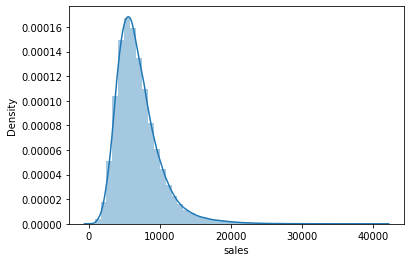

In [ ]:
sns.distplot(df4['sales'],kde=True)
plt.show()

5.1.2 4.1.2. Numerical Variable

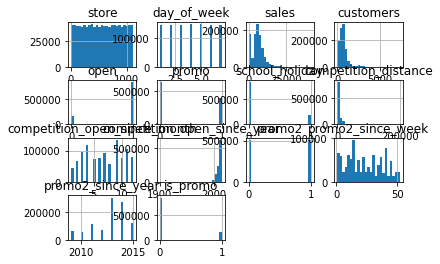

In [ ]:
num_attributtes.hist( bins=25 );


In [ ]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

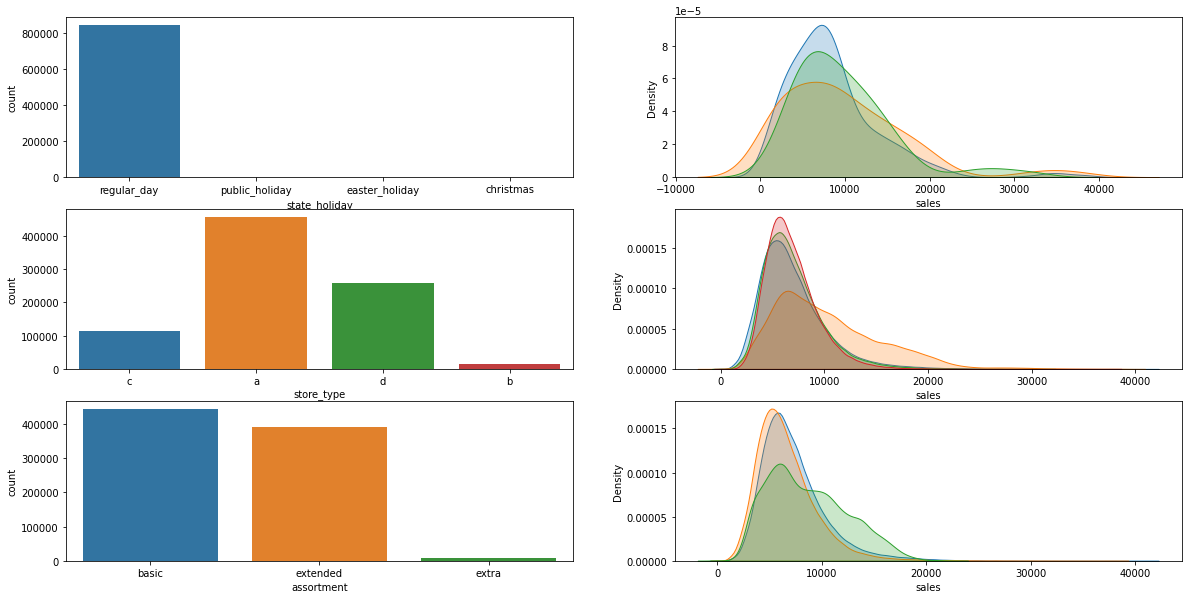

In [ ]:
plt.figure(figsize=(20,10))
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df4['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )

# store_type

plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )
plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment

plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )
plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'],label= 'extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True )

plt.show()

5.2.1 H1. Stores with larger assortments might sell more.

FALSE Stores with BIGGER ASSORTMENT sell LESS.

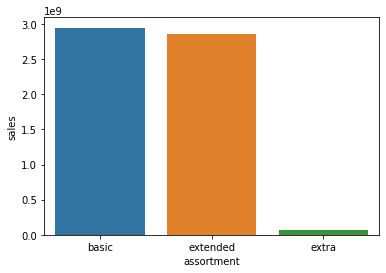

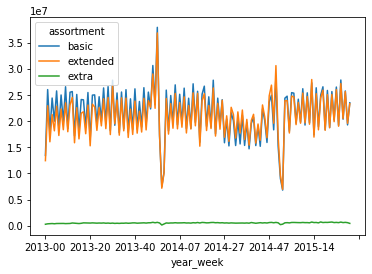

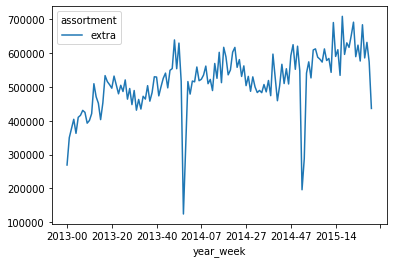

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()

sns.barplot( x='assortment', y='sales', data=aux1 )
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

plt.show()


5.2.2 H2. Stores with closer competitors might sell less.

FALSE Stores with NEAREST COMPETITORS sell MORE.


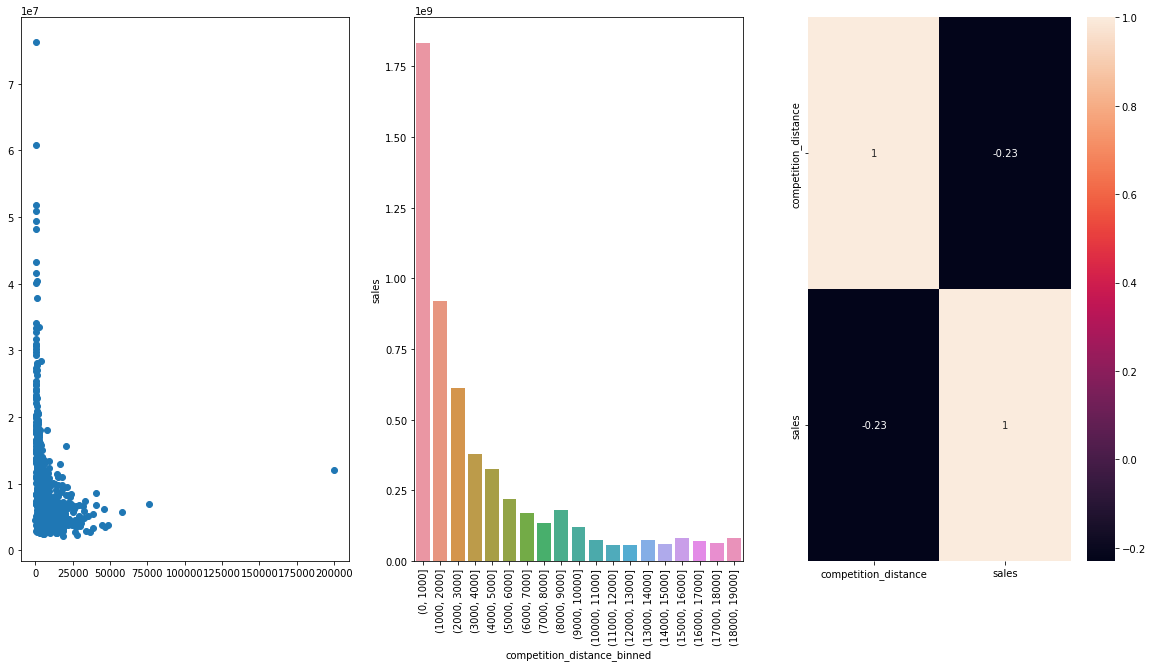

In [ ]:
plt.figure(figsize=(20,10))

aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
plt.scatter( x ='competition_distance', y = 'sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )

aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x = 'competition_distance_binned',y = 'sales', data = aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,3)

sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

plt.show()

5.2.3 H3. Stores with longer competitors should sell more.

False - Stores with LONGER COMPETITORS sell LESS

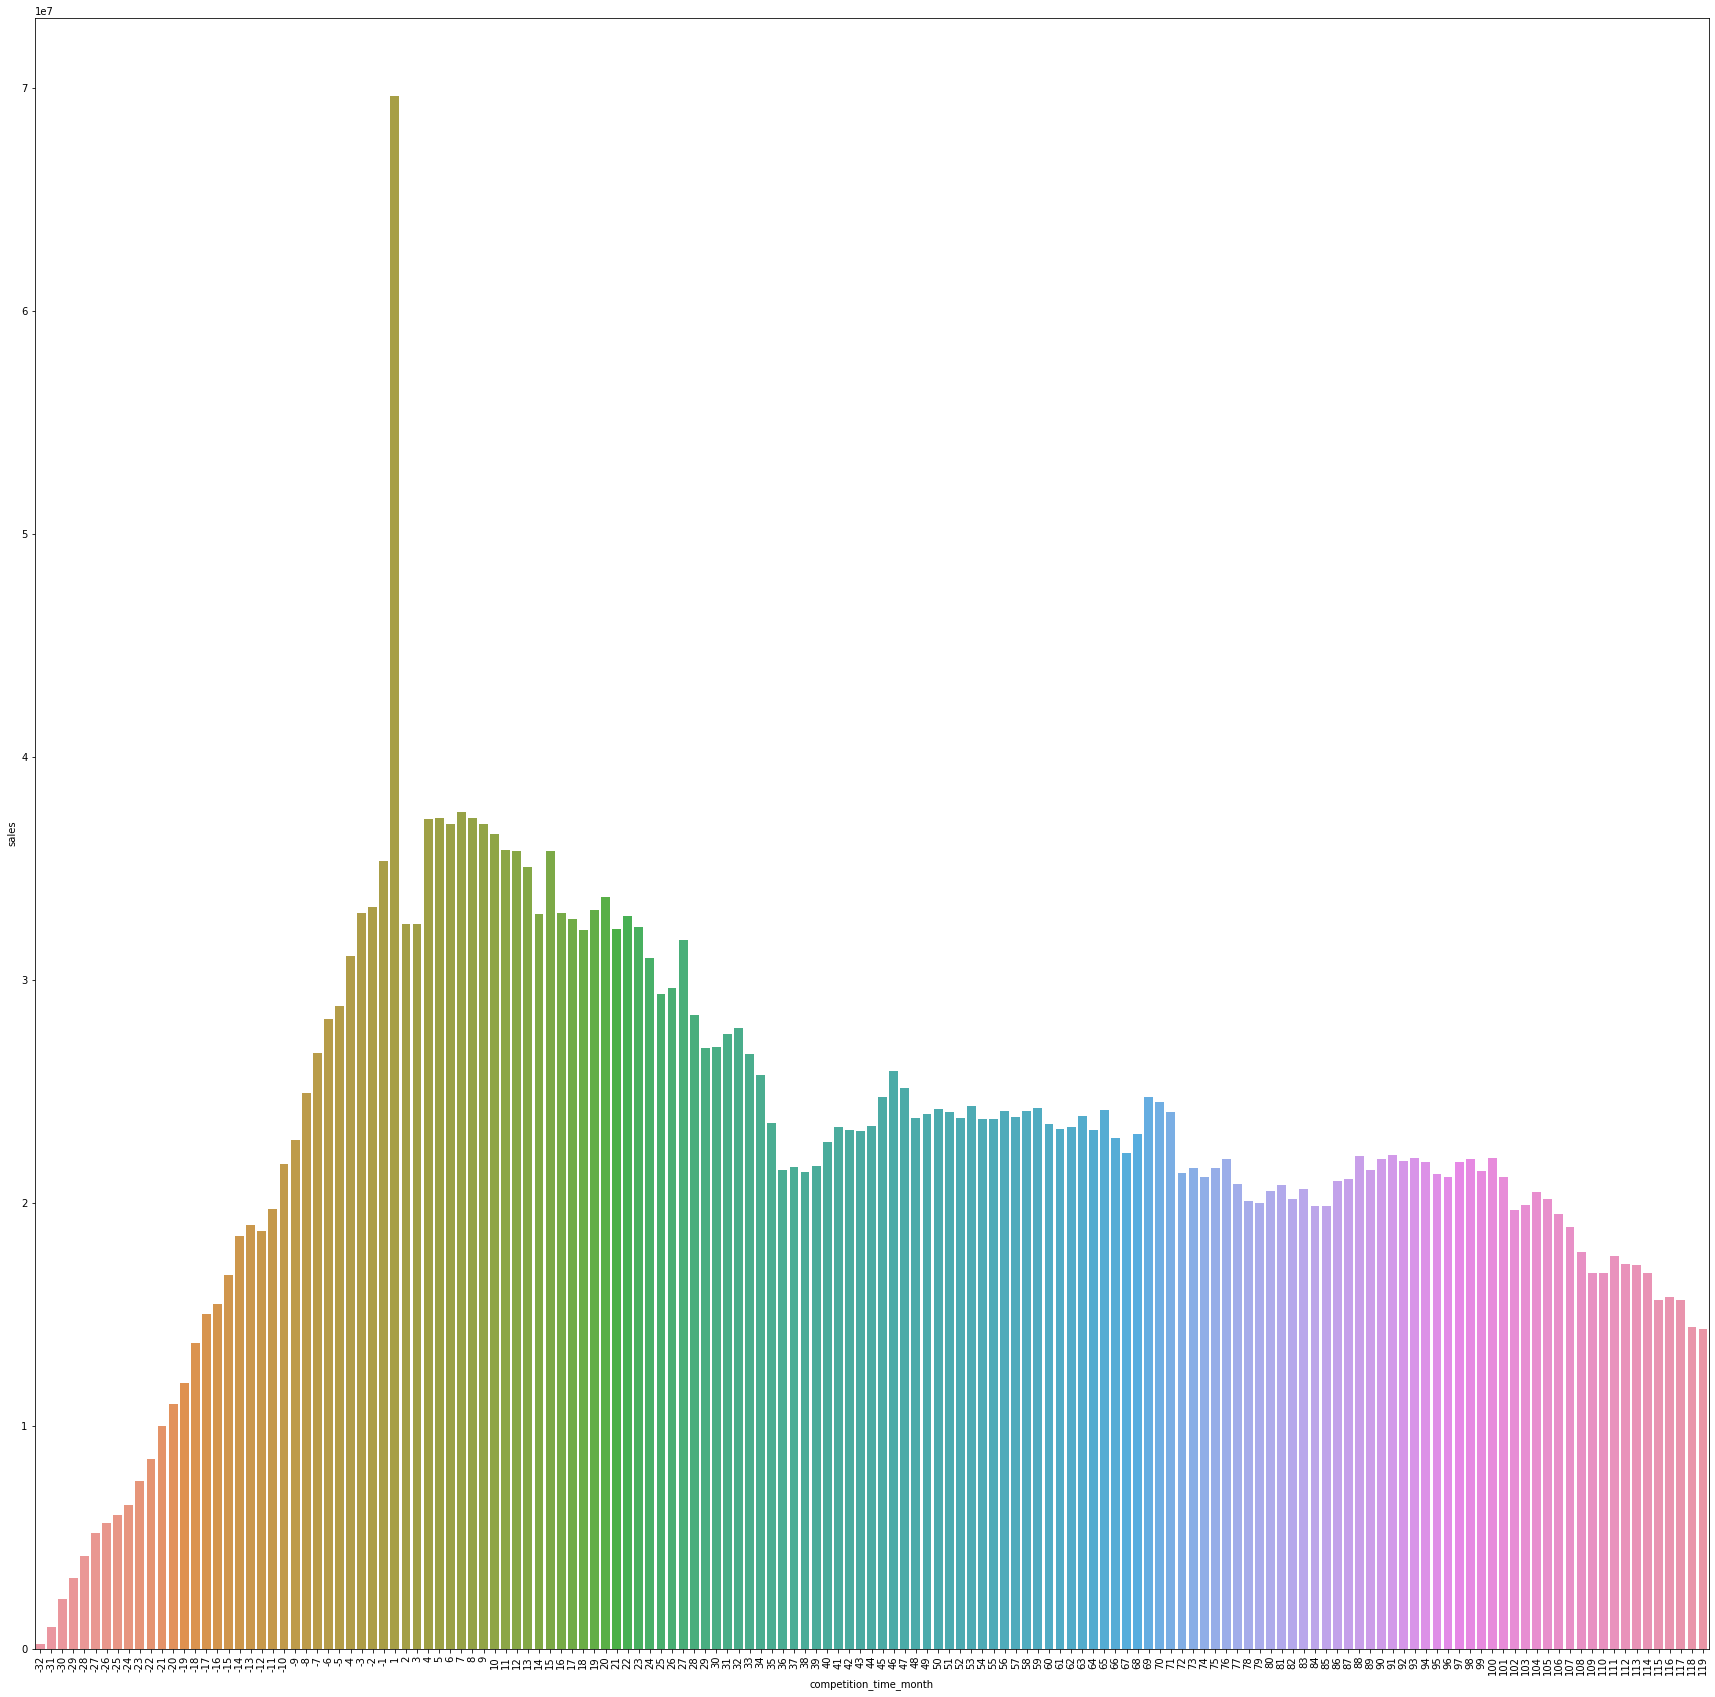

In [ ]:

plt.figure(figsize=(30,30))

aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()


aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0)]


sns.barplot(x = 'competition_time_month',y = 'sales' , data=aux2 );
plt.xticks(rotation = 90);

plt.show()

5.2.3 H3. Stores open during the Christmas holiday might sell more.

FALSE Stores open during the Christmas holiday sell less.


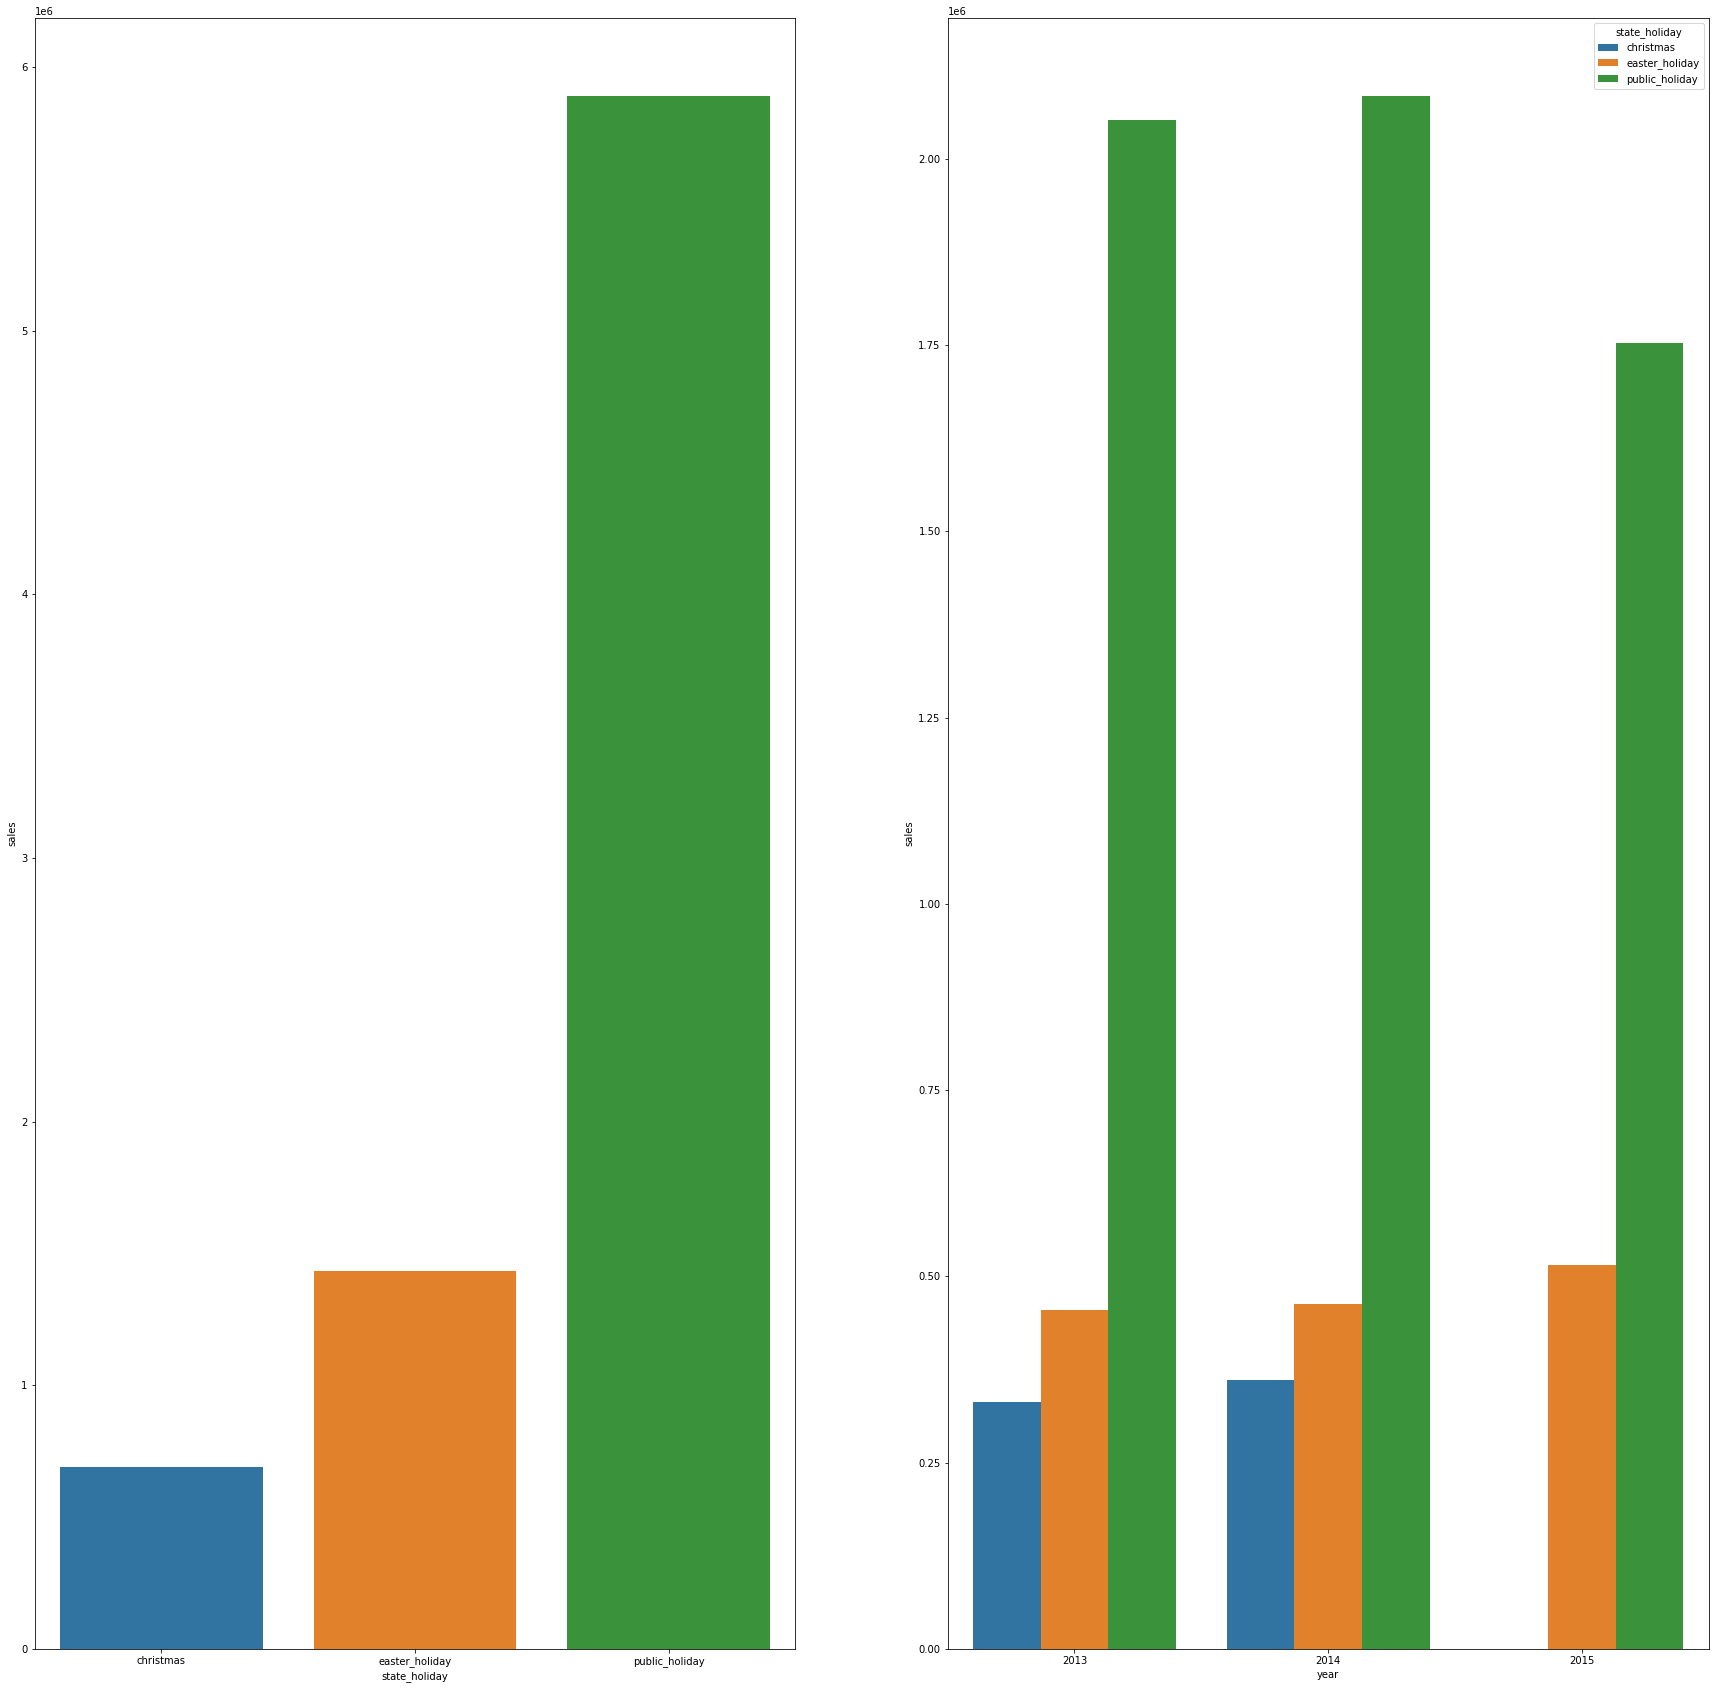

In [ ]:
plt.figure(figsize=(30,30))
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )

aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot ( x ='state_holiday', y='sales', data= aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

5.2.4 H4. Stores should sell more over the years.

FALSE Stores sell less over the years


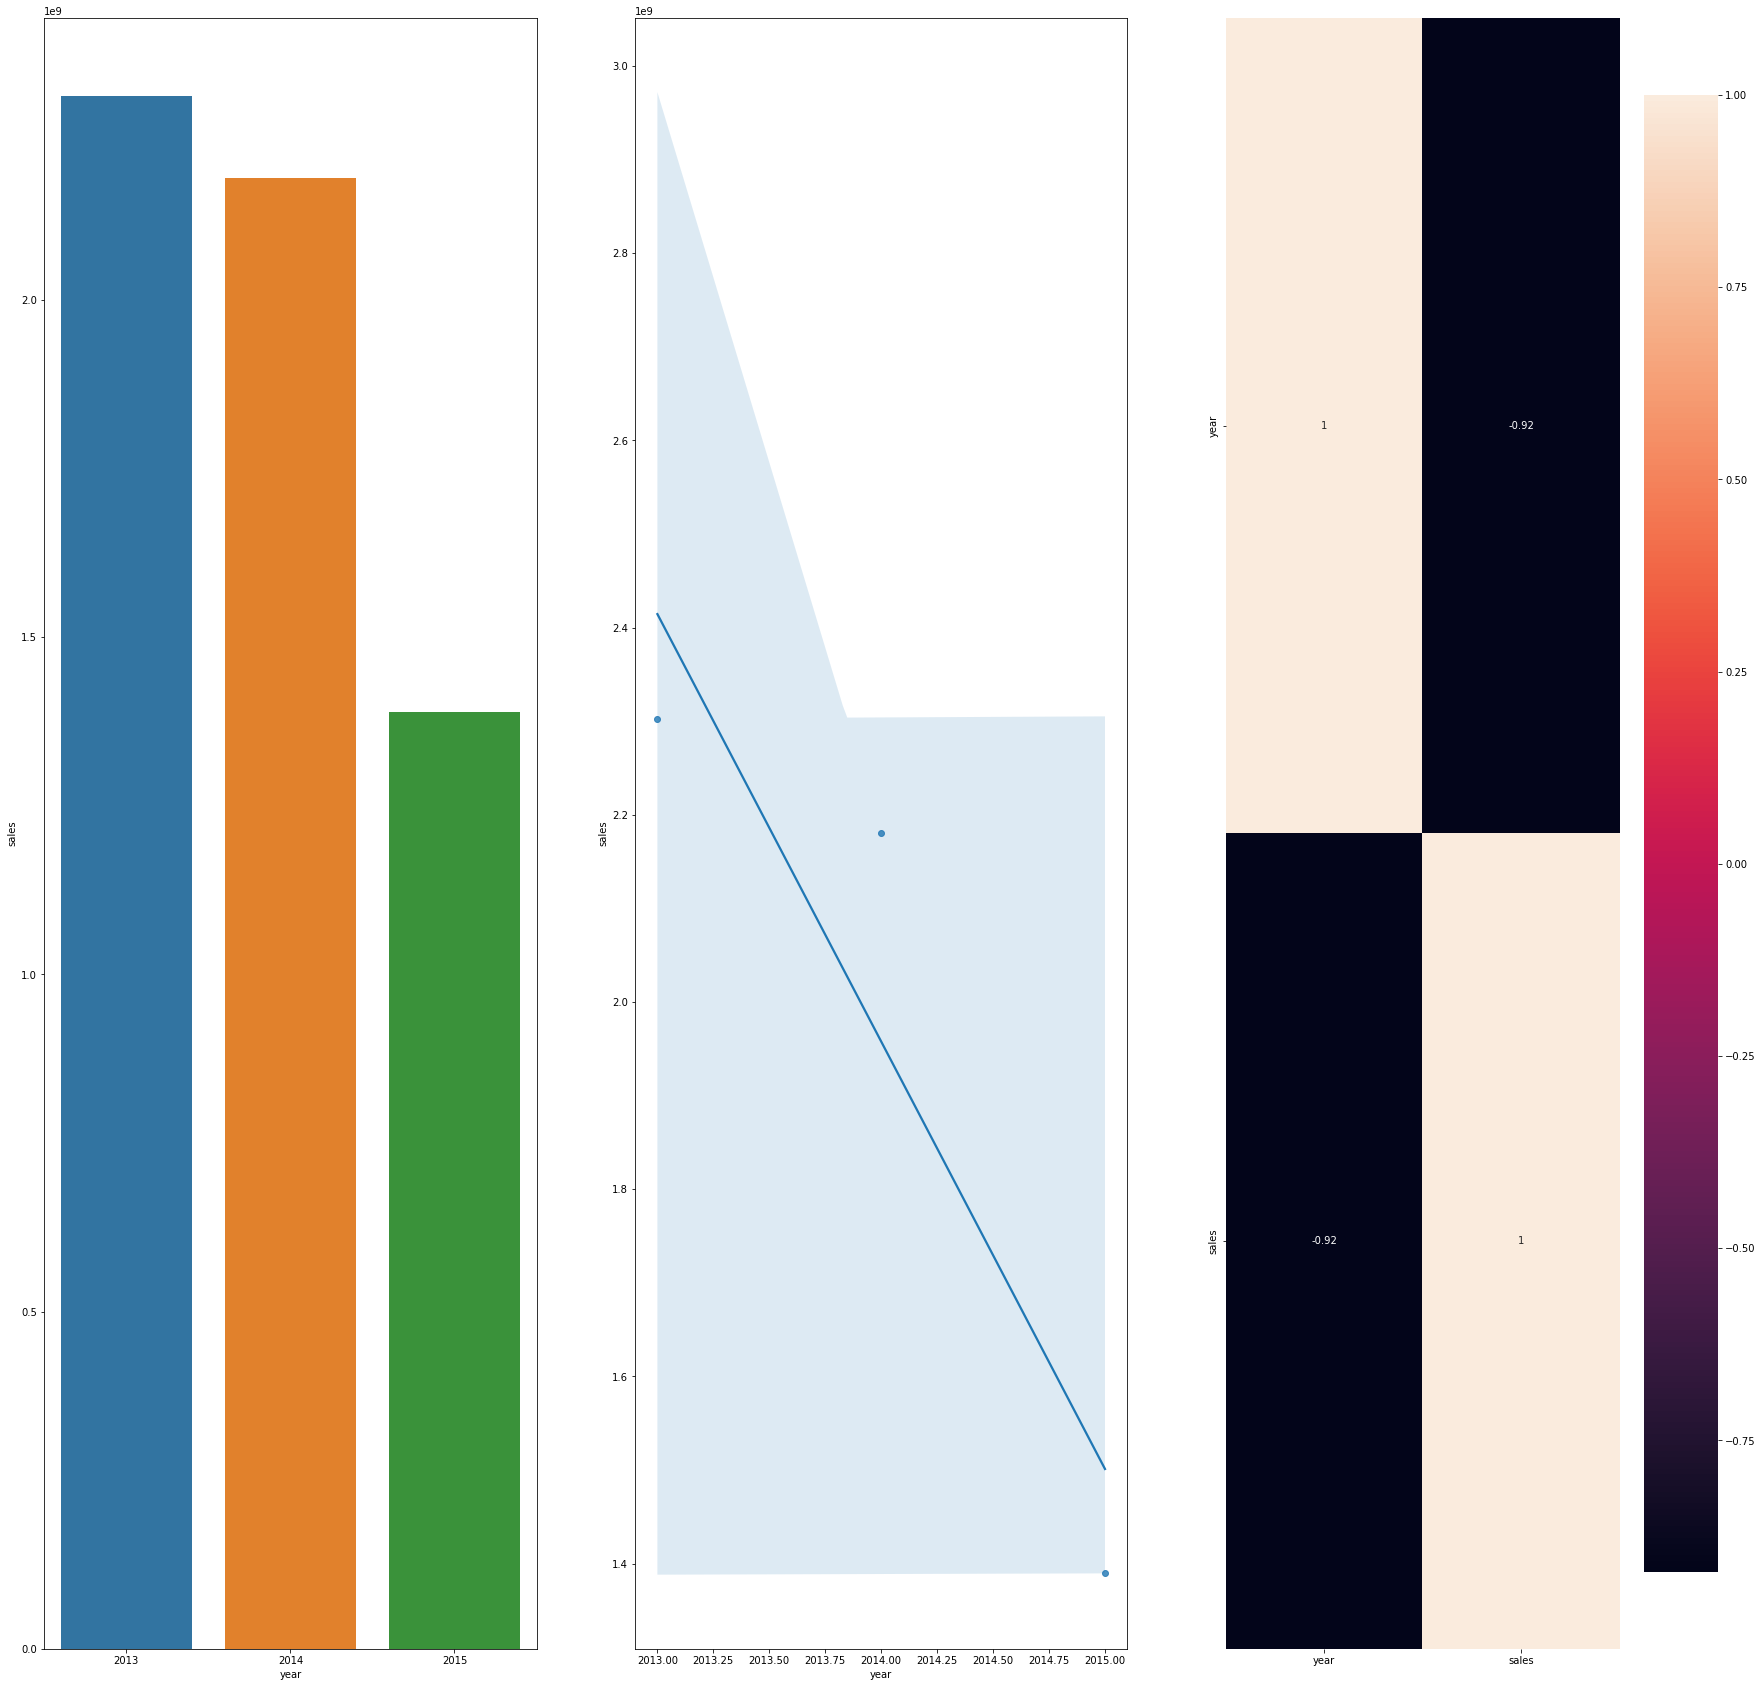

In [ ]:
plt.figure(figsize=(30,30))

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )

sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


5.2.5 H5. Stores might sell more in the second half of the year.

FALSE Stores sell less in the second half of the year

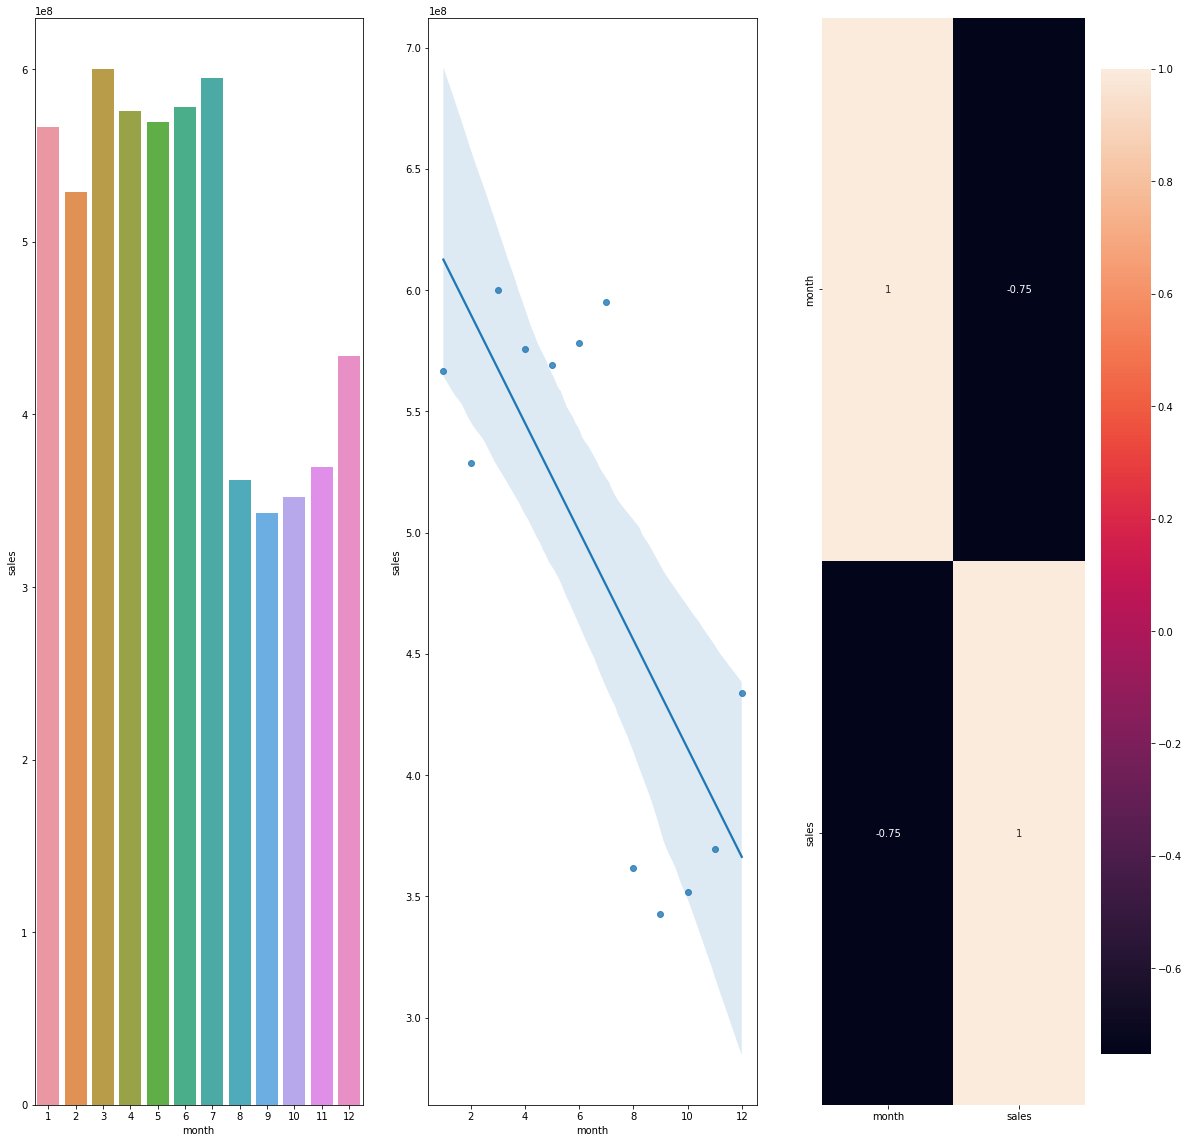

In [ ]:
plt.figure(figsize=(20,20))


aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);


plt.show()

5.2.6 H6. Stores should sell more after the 10th of each month.

TRUE Stores sell more after the 10th of each month.


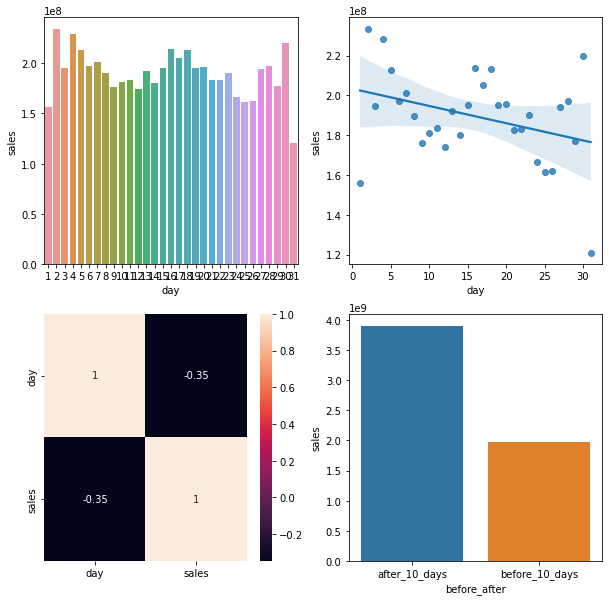

In [ ]:
plt.figure(figsize=(10,10))


aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day',y = 'sales', data = aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y= 'sales' , data= aux2);

plt.show()

5.2.7 H7. Stores might sell less during school holidays.

TRUE Stores sell less during school holidays, except July and
August

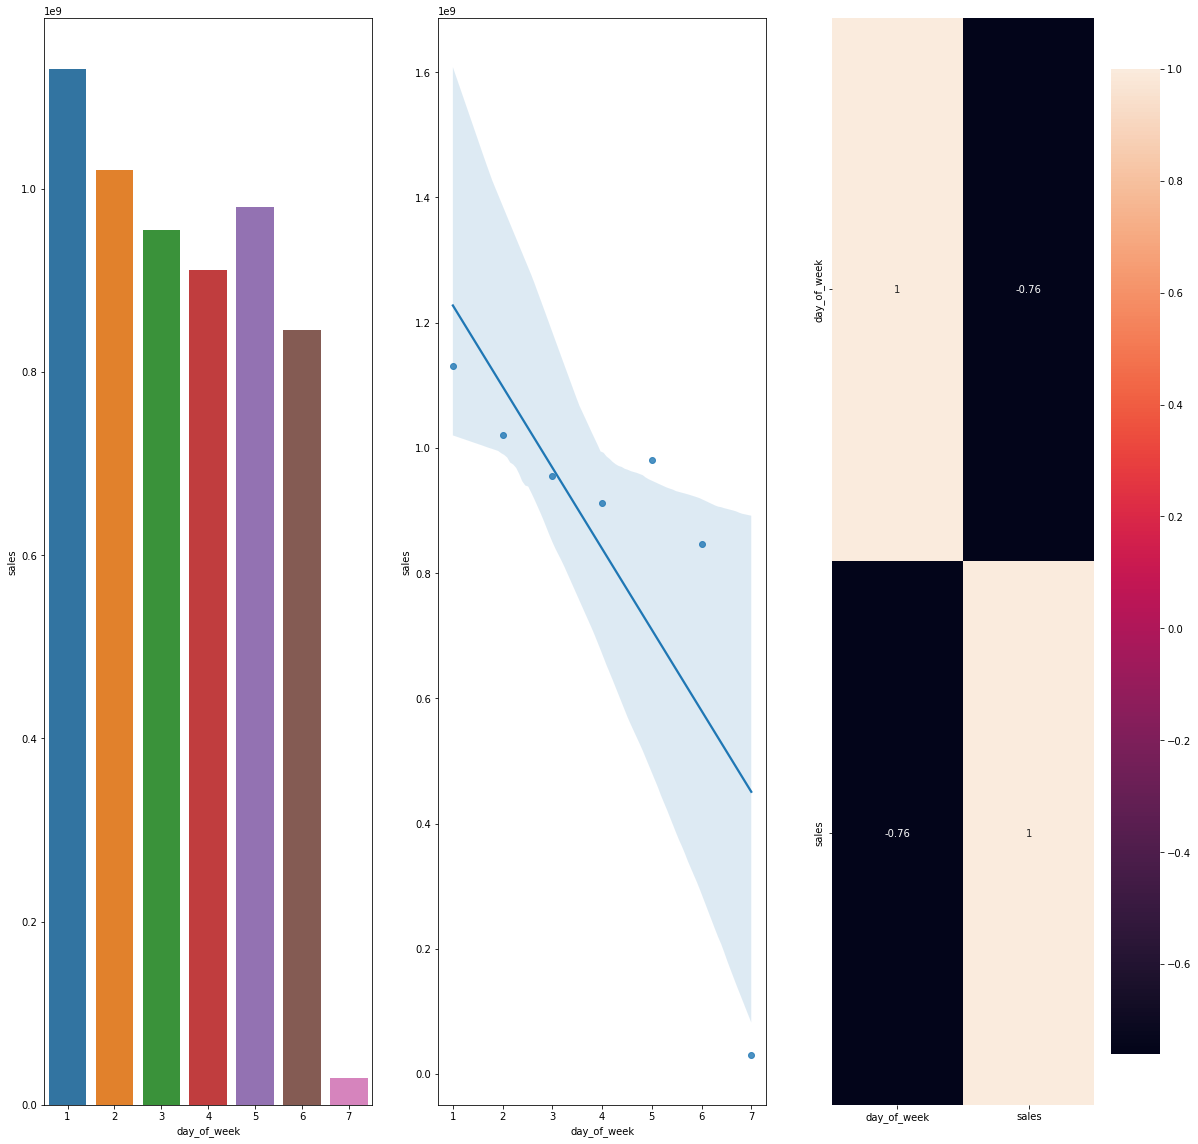

In [ ]:
plt.figure(figsize=(20,20))


aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week',y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'),annot=True);


plt.show()

5.2.8 H8. Stores might sell less during school holidays.

TRUE Stores sell less during school holidays, except July and
August.


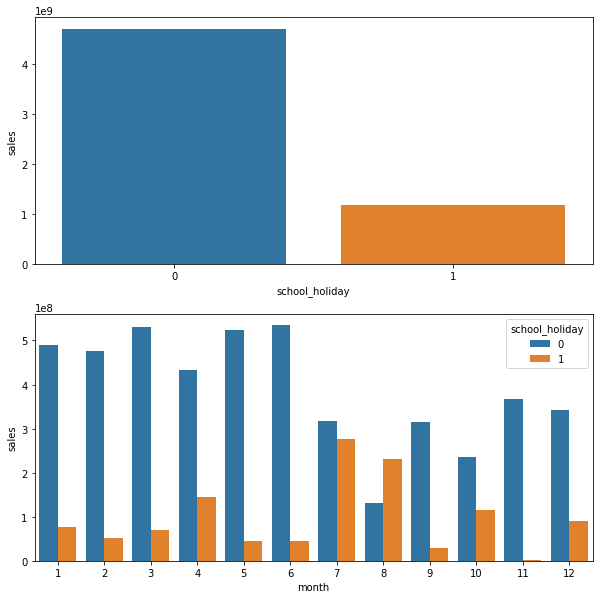

In [ ]:
plt.figure(figsize=(10,10))


aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday',y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

sns.barplot(x='month', y='sales', hue= 'school_holiday', data = aux2);

plt.show()


5.3 Summary of Hypotheses



In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


5.3.1 Multivariate analysis

5.3.1 2. Numerical Attributes

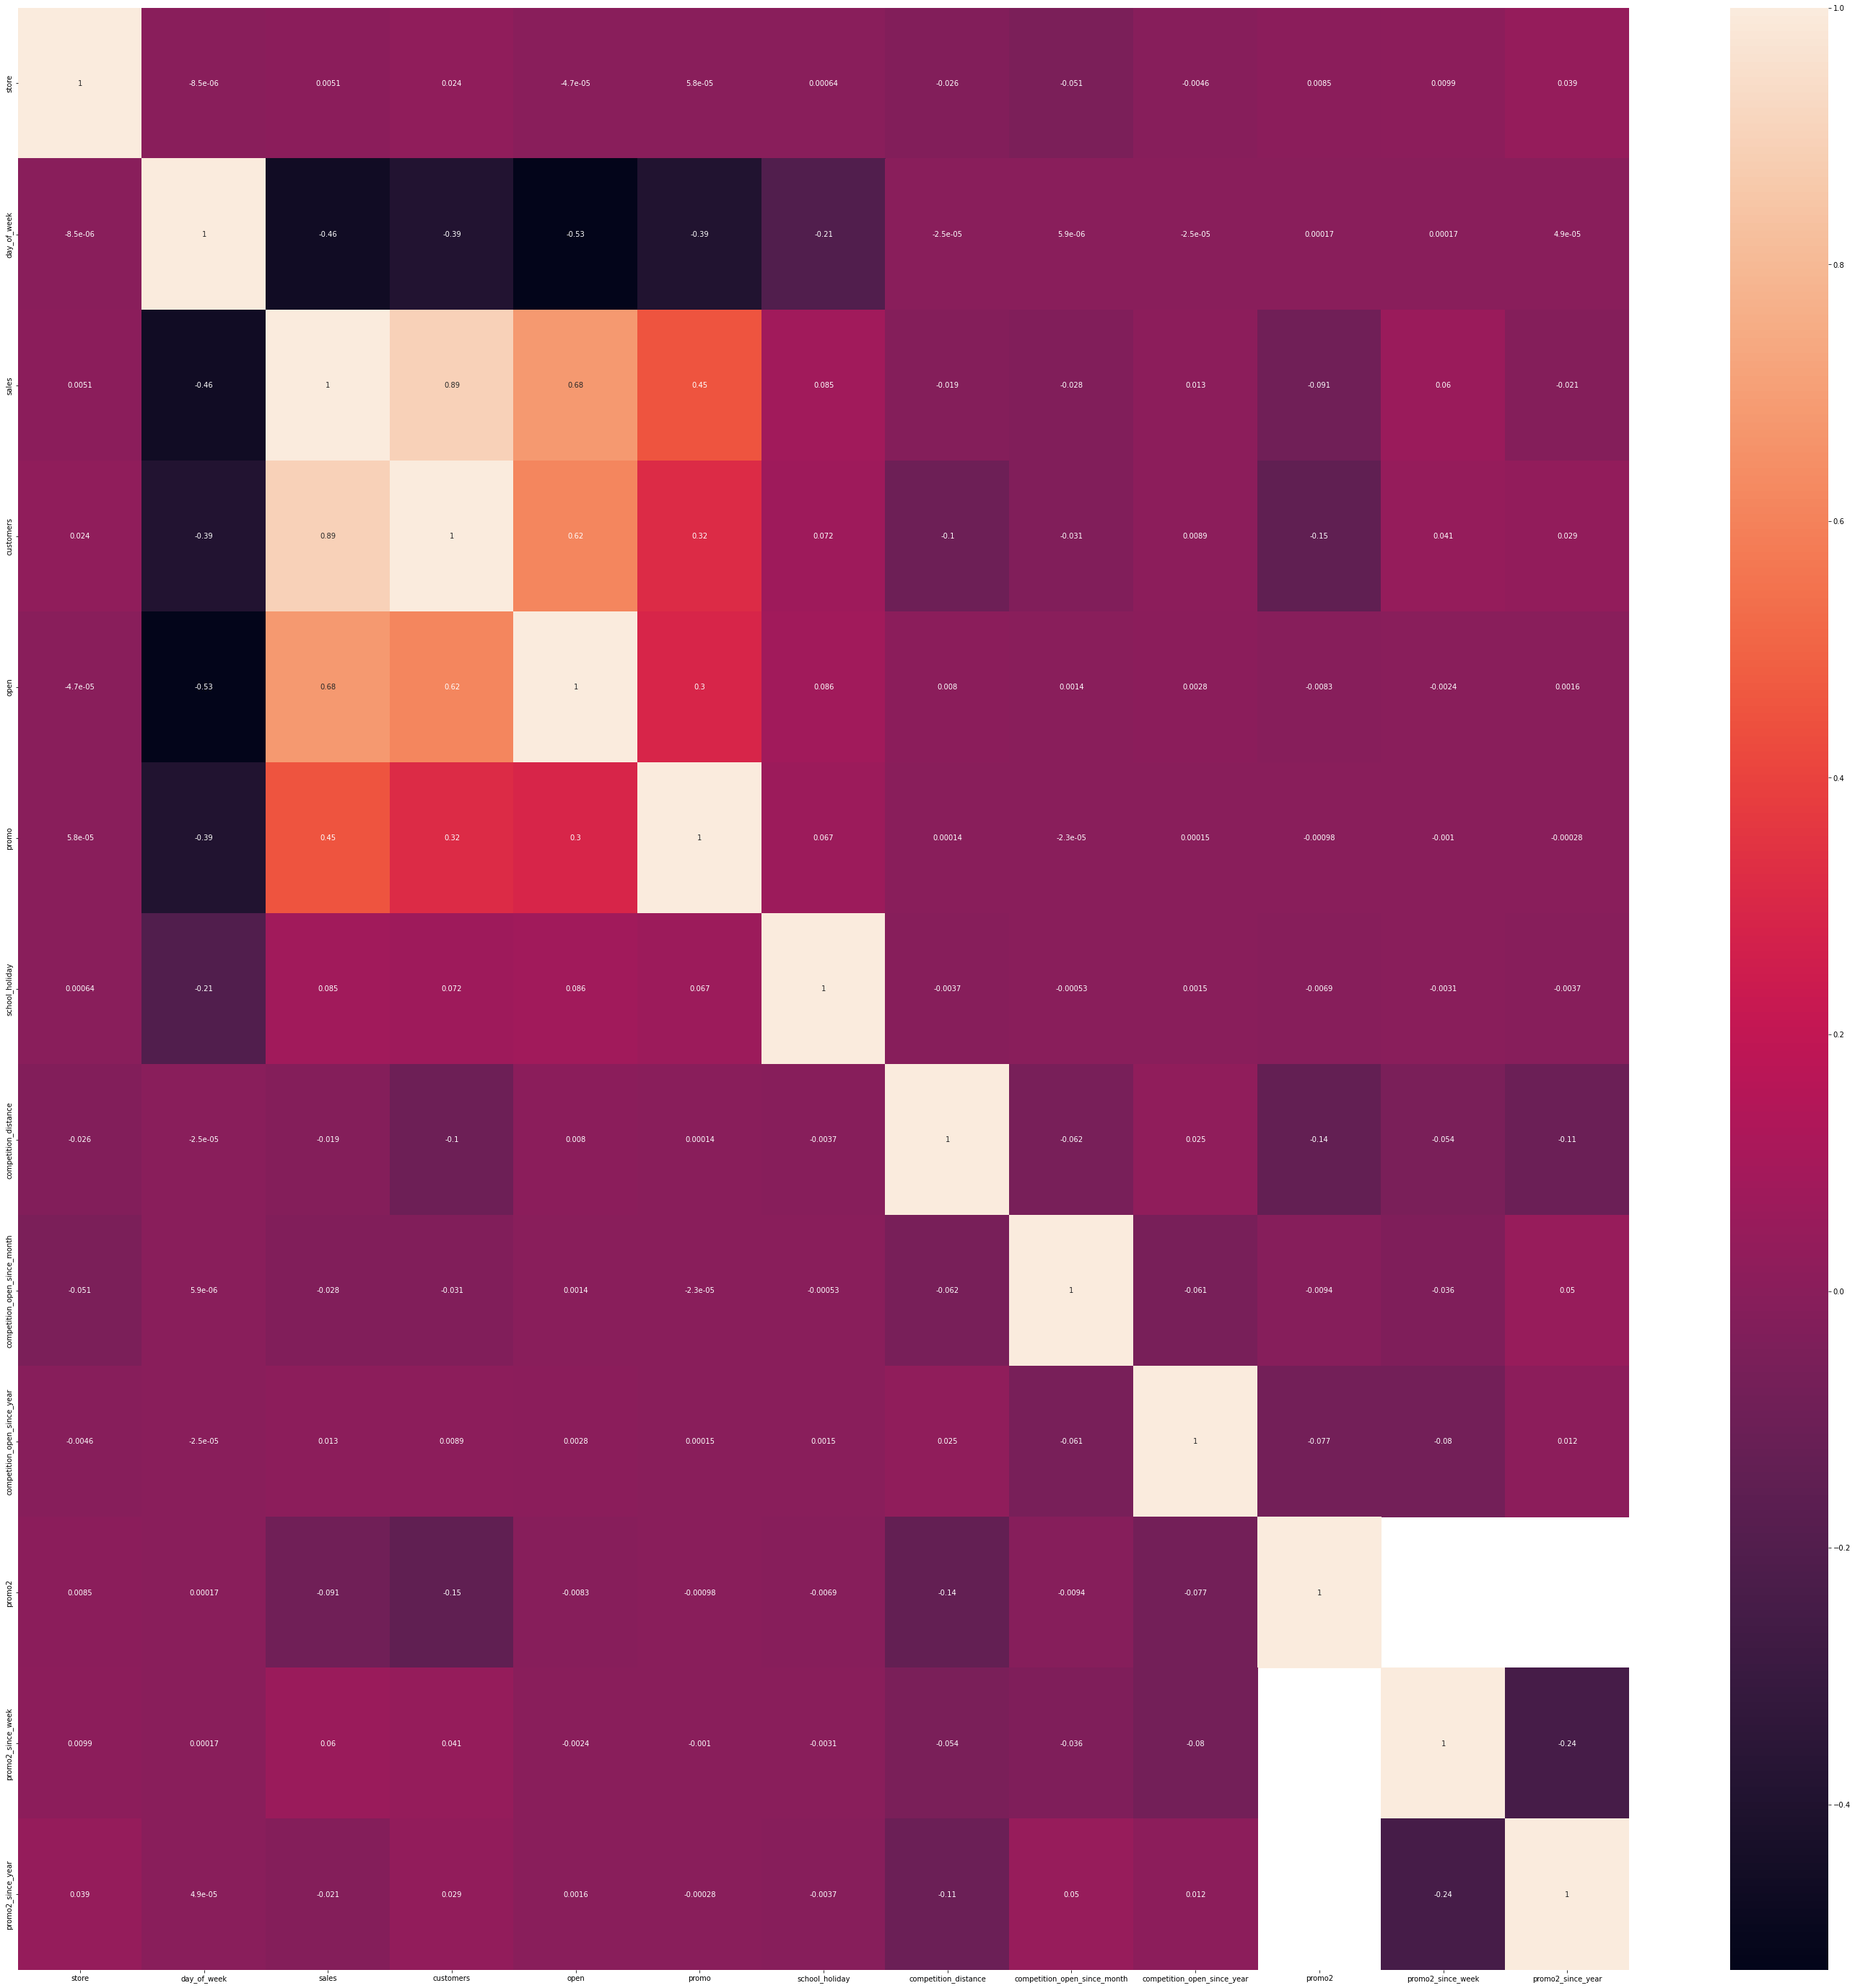

In [ ]:
plt.figure(figsize=(50,50))

correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

plt.show()

5.3.3 2. Categorical Attributes

In [ ]:
# only categorical data
a = df4.select_dtypes( include= ['object'] )

In [ ]:
cm = pd.crosstab( a['state_holiday'],a['store_type']).values

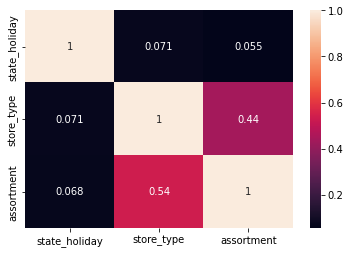

In [ ]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],'store_type': [a4, a5, a6],'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )



#6 5.0. STEP 05 - DATA PREPARATION

In [ ]:
df5 = df4.copy()

6.1 5.1. Normalization

In [ ]:
## Normalização
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


6.2 5.2. Rescaling

In [ ]:
a = df5.select_dtypes( include = ['int64','float64'])

In [ ]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


6.3 5.3. Transformacao

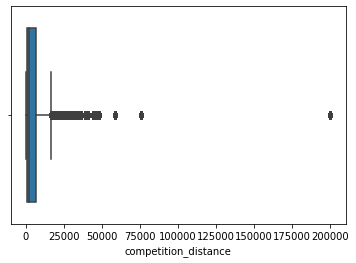

In [ ]:
sns.boxplot(df5['competition_distance'])

plt.show()

6.2 5.2. Rescaling


In [ ]:
rs = RobustScaler()

In [ ]:
# competition distance
df5['competition_distace'] = rs.fit_transform( df5[['competition_distance']].values )
# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# promo time week
df5['promo_time_week'] = rs.fit_transform( df5[['promo_time_week']].values )
# year
df5['year'] = rs.fit_transform( df5[['year']].values )

6.3 5.3. Transformacao


6.3.1 5.3.1. Encoding

In [ ]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

In [ ]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

In [ ]:
# assortment - Ordinal Encoding
assortment_dict = {'basic' : 1,'extra' :2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

6.3.2 5.3.2. Response Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales'])

6.3.3 5.3.3. Nature Transformation

In [ ]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

#day
df5['day_sin'] = df5['day'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
df5['day_cos'] = df5['day'].apply(lambda x:np.cos(x*(2.*np.pi/12)))


#month
df5['month_sin'] = df5['month'].apply(lambda x:np.sin(x*(2.* np.pi/30)))
df5['month_cos'] = df5['month'].apply(lambda x:np.cos(x*(2.* np.pi/30)))


#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2.*np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2.*np.pi/52) ) )

#7 6.0. STEP 06 - FEATURE SELECTION

In [ ]:
df6 = df5.copy()

7.1 6.1. Split dataframe into training and test dataset


In [ ]:
#training data set

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print(' Training Min Date:{}'.format( X_train['date'].min() ))
print(' Training Max Date:{}'.format( X_train['date'].max() ))

print('\ntest Min Date:{}'.format(X_test['date'].min() ))
print(' Test Max Date:{}'.format(X_test['date'].max() ))

 Training Min Date:2013-01-01 00:00:00
 Training Max Date:2015-06-18 00:00:00

test Min Date:2015-06-19 00:00:00
 Test Max Date:2015-07-31 00:00:00


7.2 6.2. Boruta as Feature Selector

In [ ]:
# x training and test dataset for boruta


#X_train_n = X_train.drop(['date','sales'],axis = 1).values
#y_train_n = y_train.values.ravel()

#define rangom forest regression


#rf = RandomForestRegressor(n_jobs =-1)

#Define boruta

#
#boruta = BorutaPy(rf, n_estimators= 'auto', verbose=2 , random_state=42).fit(X_train_n, y_train_n)

7.2.1 6.2.1. Best Features from Boruta

cols_selected = boruta.support_.tolist()

best features
X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

not selected boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,␣
,→cols_selected_boruta ) )

7.3 6.3. Manual Feature Selection

In [ ]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']
# columns to add

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


#8 7.0. STEP 07 - MACHINE LEARNING MODELLING

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

8.1 7.1. Average Model

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predictions
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how = 'left',on = 'store')
yhat_baseline = aux1['predictions']

#performance

baseline_result= ml_error('Average Model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


8.2 7.2. Linear Regression Model


In [ ]:
#model

lr= LinearRegression().fit(x_train,y_train)

#prediction

yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1885.91941,0.29111,2713.326465


8.2.1 7.2.3. Linear Regression Model - Cross Validation

In [ ]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv

8.2 7.4. Linear Regression ModelLinear regression Regularized Model - Lasso

In [ ]:
#model

lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction

yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1895.222982,0.289527,2748.632263


8.4 7.5 Lasso - Cross Validation

In [ ]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

8.4 7.6. Random Forest Regressor


In [ ]:
#model

rf = RandomForestRegressor(n_estimators = 100,n_jobs = -1,random_state = 42).fit(x_train, y_train)

#prediction

yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regression',np.expm1(y_test),np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,667.078649,0.098757,996.177999


8.4 7.7 Random Forest Regressor - Cross Validation


In [ ]:
rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf, verbose = False)
rf_result_cv

8.4 7.8 Xgbooster Regressor

In [ ]:
#model

model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 100,eta = 0.01,max_depth = 10,subsample = 0.7, colsample_bytee=0.9).fit(x_train, y_train)

#prediction

yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGboost Regressor',np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,865.170269,0.12259,1296.382718


8.5.1 7.9 XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',model_xgb, verbose = False)
xgb_result_cv

8.4 7.9 Compare Model Performance

8.6.1 7.10 Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result,lr_result, lrr_result, rf_result, xgb_result])

modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regression,667.078649,0.098757,996.177999
0,XGboost Regressor,865.170269,0.122590,1296.382718
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1885.919410,0.291110,2713.326465
0,Linear Regression - Lasso,1895.222982,0.289527,2748.632263


8.6.2 .11 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

# 9 8.0. STEP 08 - HYPERPARAMETER FINE TUNING

9.1 8.1. Random Search

In [ ]:


#param= {
#    'n_estimators':[1500,1700,2500,3000,3500],
#    'eta': [0.01,0.03],
#    'max_depth':[3,5,9],
#    'subsample':[0.1, 0.5, 0.7],
#    'colsample_bytee':[0.3,0.7, 0.9],
#    'min_child_weight':[3,8,15]
#        }

#MAX_EVAL = 10

9.2 8.2. Final Model


In [ ]:
#final_result = pd.DataFrame() 
    
#for i in range (MAX_EVAL):
    #choose values for parameters randomly
    hp = { k:random.sample( v,1 )[0]for k,v in param.items() } 
    print(hp)


#model

    model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                             n_estimators = hp['n_estimators'],
                             eta = hp['eta'],
                             max_depth = hp['max_depth'],
                             subsample = hp['subsample'],
                             colsample_bytee= hp ['colsample_bytee'],
                             min_child_weight= hp['min_child_weight'])


#performance
    result= cross_validation(x_training,2,'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat( [final_result, result])

#final_result

9.2 8.2. Final Model


In [ ]:
param_tuned= {
    'n_estimators':3000,
    'eta':0.03 ,
    'max_depth':5,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3
        }


In [ ]:
#model

model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = param_tuned['n_estimators'],
                             eta = param_tuned['eta'],
                             max_depth = param_tuned['max_depth'],
                             subsample = param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train,y_train)

#prediction

yhat_xgb_tuned = model_xgb_tuned.predict( x_test)


#performance

xgb_result_tuned = ml_error('XGboost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
xgb_result_tuned

In [ ]:
import pickle

In [ ]:
#saving model trainned
filename = 'xgb_result_tuned'
pickle.dump(xgb_result_tuned,open(filename,'wb'))

#10 9.0 STEP 09 - TRANSLATION AND INTERPRETATION OF ERROR

In [ ]:
df9=X_test[cols_selected_boruta_full]

#rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

10.1 9.1. Business Performance


In [ ]:
df91= df9[['store','predictions']].groupby('store').sum().reset_index()

#mae and mape

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#merge

df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on = 'store')
df92= pd.merge(df91,df9_aux3,how='inner',on = 'store')


#scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df92.sample(4)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
133,134,176580.50000,176168.420641,176992.579359,412.079359,0.088035
362,363,263772.28125,263200.110022,264344.452478,572.171228,0.078444
243,244,198726.40625,197941.713445,199511.099055,784.692805,0.143037
761,762,156958.34375,156483.116033,157433.571467,475.227717,0.106067


In [ ]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104070.859375,100741.304842,107400.413908,3329.554533,0.546526
908,909,237448.359375,229703.155847,245193.562903,7745.203528,0.521742
1038,1039,384091.468750,381212.524388,386970.413112,2878.944362,0.384424
875,876,211534.265625,207452.908798,215615.622452,4081.356827,0.340491
721,722,356797.250000,354702.621437,358891.878563,2094.628563,0.280525


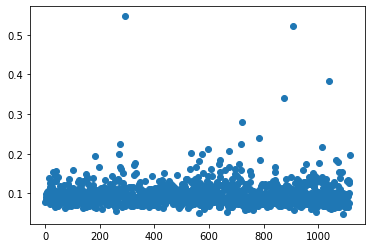

In [ ]:
plt.scatter( x ='store', y='MAPE', data= df92)

plt.show()

10.2 9.2. Total Performance


In [ ]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x:np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenario',0:'Values'})
df93['Values']= df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$286,146,240.00"
1,worst_scenario,"R$285,394,334.36"
2,best_scenario,"R$286,898,117.87"


10.3 9.3. Machine Learning Performance


In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_state'] = df9['predictions']/df9['sales']

ValueError: ignored

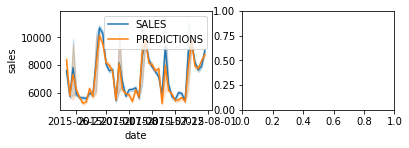

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )

sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )

sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

#10.0. STEP 10 - DEPLOY MODEL TO PRODUCTION

11.1 10.1. Rossmann Class


In [ ]:
loaded_model = pickle.load(open(filename,'rb'))

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path= loaded_model
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

11.1 10.1. Rossmann Class

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
import Rossmann

# loading model
model = pickle.load( open( filename, 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [ ]:
dataset_test1 = "/content/test.csv"
df10 = pd.read_csv(dataset_test1, low_memory=False )


In [ ]:
#API TESTER

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )
# choose store for prediction
df_test = df_test[df_test['Store'].isin( [19, 23, 22] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [ ]:
import json

In [ ]:
data = json.dumps( df_test.to_dict( orient='records' ) )


In [ ]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [ ]:
import requests

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )


In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
  print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
        d2.loc[i, 'store'],
        d2.loc[i, 'prediction'] ) )


Store Number 19 will sell R$226,386.12 in the next 6 weeks
Store Number 22 will sell R$143,515.77 in the next 6 weeks
Store Number 23 will sell R$216,843.37 in the next 6 weeks
